# Best Random Forest Model

The bias is the same as the baseline model.

results.txt:
- Data: year=2014, month=01-01, size=mid
- Time (in seconds): 87767 = 24h22m
- [('maxDepth', 30), ('minInstancesPerNode', 1), ('numTrees', 300)] - 0.0331134166639611 -

In [2]:
import pyspark
from pyspark.ml import PipelineModel
from utils import sparkutils, modelutils

import matplotlib
import matplotlib.pyplot as plt

In [3]:
spark = pyspark.sql.SparkSession.builder\
.appName("Rides Preprocessor")\
.master("local")\
.config("spark.local.dir", "/home/atkm/nycTaxi/tmp")\
.config("spark.driver.memory", "4g")\
.getOrCreate()

In [4]:
def get_ride_data(year, month, size='tiny'):
    return f'data/yellow_tripdata_{year}-{month:02}_{size}.csv'

def get_metar_data(year, month):
    return f'data/metar_data/lga_{year}-{month:02}.csv'

def read_csv(path):
    return spark.read.format("csv")\
      .option("header", "true")\
      .option("inferSchema", "true")\
      .load(path)

def load_metar(metarPath):
    metar = read_csv(metarPath)
    metar = metar.select("valid","tmpf", " p01i") # note whitespace in p01i
    return metar.withColumnRenamed('valid', 'datetime')\
        .withColumnRenamed('tmpf', 'fahrenheit')\
        .withColumnRenamed(' p01i', 'precip_in')

def load_rides(ridesPath):
    rides = read_csv(ridesPath)
    # 2014
    colNames = map(lambda name: name.strip(), rides.columns)
    rides = rides.toDF(*colNames)
    return rides.select("pickup_datetime","pickup_latitude", "pickup_longitude")


In [5]:
model = PipelineModel.load('training_results/rfmodel_1536387410/rfmodel_1536387410.model/')

In [6]:
rf_pmap = model.stages[1]
rf_pmap.getParam('numTrees')

Param(parent='RandomForestRegressor_4ac0ba16b695c1095c59', name='numTrees', doc='Number of trees to train (>= 1)')

In [7]:
rides = sparkutils.count_rides(
    load_rides(get_ride_data(2014,2,'small'))
)
metar = sparkutils.clean_metar(
    load_metar(get_metar_data(2014,2))
)
joined = sparkutils.join_rides_metar(rides,metar)

In [8]:
pred = model.transform(joined)

In [9]:
pred.count()

48801

In [10]:
pred.select('grid_x','grid_y','count_scaled','fahrenheit','precip_in','weekday','hour','prediction').show(5)

+------+------+--------------------+----------+---------+-------+----+--------------------+
|grid_x|grid_y|        count_scaled|fahrenheit|precip_in|weekday|hour|          prediction|
+------+------+--------------------+----------+---------+-------+----+--------------------+
|     5|    33| 0.02158273381294964|      32.0|      0.0|      2|  19|0.011351272672355394|
|     4|    32|0.007194244604316547|      32.0|      0.0|      2|  19|0.007173798548970301|
|     6|    29| 0.03597122302158273|      32.0|      0.0|      2|  19|0.042052977138908564|
|     5|    32| 0.02158273381294964|      32.0|      0.0|      2|  19|0.007699720491528302|
|     7|    31|0.007194244604316547|      32.0|      0.0|      2|  19|0.014312780024728643|
+------+------+--------------------+----------+---------+-------+----+--------------------+
only showing top 5 rows



In [11]:
df = pred.select('grid_x','grid_y','count_scaled','fahrenheit','precip_in','weekday','hour','prediction').toPandas()

In [12]:
df.head()

,grid_x,grid_y,count_scaled,fahrenheit,precip_in,weekday,hour,prediction
0,5,33,0.021583,32.0,0.0,2,19,0.011351
1,4,32,0.007194,32.0,0.0,2,19,0.007174
2,6,29,0.035971,32.0,0.0,2,19,0.042053
3,5,32,0.021583,32.0,0.0,2,19,0.007700
4,7,31,0.007194,32.0,0.0,2,19,0.014313


In [13]:
df['residual'] = df['prediction'] - df['count_scaled']

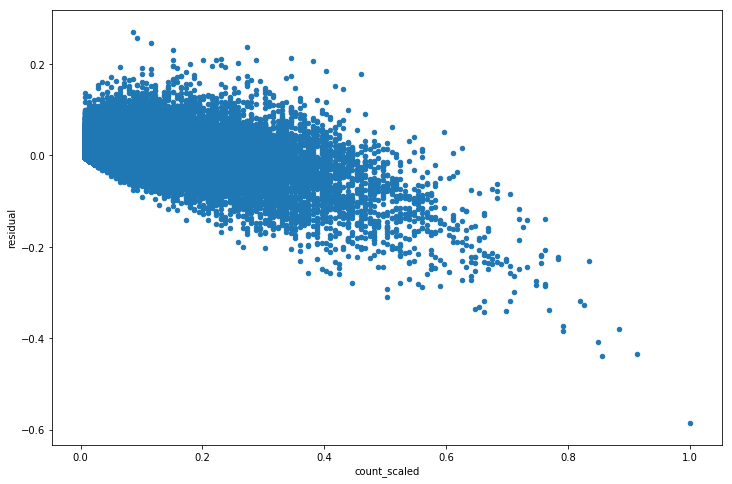

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
df.plot.scatter('count_scaled', 'residual', ax=ax)